In [4]:
import pandas as pd 
import numpy as np
from rebin import rebin 

import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.metrics import median_absolute_error as mae_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.multioutput import RegressorChain

spectral_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/count_rates_initial_exploration/count_rates_transposed.csv?token=GHSAT0AAAAAABP54PQOCRFDLULKZIMBHSOKYROHGDQ')
qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/xspec_related/better-organization/analysis-routines/qpo_data_aggregation/results/pre-steiner-compiled.csv?token=GHSAT0AAAAAABOGNQ24QSUKKTOMTUVHWLRSYRNBDNQ')

spectral_df.sort_values(by='full_id')
qpo_df.sort_values(by='full_id')

mask = np.where(qpo_df['num_qpos']!='flagged')
qpo_df = qpo_df.iloc[mask]
mask = np.where(np.array(qpo_df['num_qpos']).astype(int)>0)
qpo_df = qpo_df.iloc[mask]

spectral_indices = []
for i in qpo_df['full_id']: 
    spectral_indices.append(np.where(spectral_df['full_id']==i)[0][0])

spectral_df = spectral_df.iloc[spectral_indices]

for i in ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']: 
    qpo_df = qpo_df.astype({i:float})

for i, j in zip(qpo_df['full_id'], spectral_df['full_id']): 
    if i!=j: 
        print('mis-match')
        print(i,j)

In [5]:
rs = 12

In [6]:
def norm(x, min, max): 
    return (x - min) / (max - min)

In [7]:
# package x values

bins = 25

x = []

for i in range(len(spectral_df.index)): 
    counts_row = np.array(spectral_df.iloc[[i]])[0][1:].astype(float) 
    
    rebin_factor = int(np.floor(len(counts_row)/bins))
    
    rebined = rebin(counts_row, rebin_factor)
    x.append(rebined)

x = np.array(x)

In [8]:
# package y values

combined_freqs = np.concatenate((qpo_df['first_freq'], qpo_df['second_freq']))
min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
combined_widths = np.concatenate((qpo_df['first_width'], qpo_df['second_width']))
min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
combined_norms = np.concatenate((qpo_df['first_norm'], qpo_df['second_norm']))
min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

y_col_names = ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']
freq1s, freq2s = (norm(np.array(qpo_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names[0:2])
width1s, width2s = (norm(np.array(qpo_df[arr_name]), min_width, max_width) for arr_name in y_col_names[2:4])
norm1s, norm2s = (norm(np.array(qpo_df[arr_name]), min_norm, max_norm) for arr_name in y_col_names[4:])

freqs = np.array([], dtype=float).reshape(0,2)
widths = np.array([], dtype=float).reshape(0,2)
norms = np.array([], dtype=float).reshape(0,2)

y_vals = []

for i in range(len(freq1s)): 
    row_matrix = np.array([freq1s[i], freq2s[i], width1s[i], width2s[i], norm1s[i], norm2s[i]])
    y_vals.append(row_matrix)

y_vals = np.array(y_vals)

print(y_vals[0])

[0.07781039 0.31648829 0.07779171 0.4233109  0.42292203 0.21152726]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y_vals, test_size=0.1, shuffle=True, random_state=rs)

In [10]:
regr = RandomForestRegressor()
regr.fit(X_train,y_train)
predictions = regr.predict(X_test)

predicted_freqs = np.array([predictions[i][0:2] for i in range(len(predictions))])
predicted_widths = np.array([predictions[i][2:4] for i in range(len(predictions))])
predicted_norms = np.array([predictions[i][4:] for i in range(len(predictions))])

test_freqs = np.array([y_test[i][0:2] for i in range(len(y_test))])
test_widths = np.array([predictions[i][2:4] for i in range(len(y_test))])
test_norms = np.array([predictions[i][4:] for i in range(len(y_test))])

mses = [mse_score(test_freqs, predicted_freqs), mse_score(test_widths, predicted_widths), mse_score(test_norms, predicted_norms)]
maes = [mae_score(test_freqs, predicted_freqs), mae_score(test_widths, predicted_widths), mae_score(test_norms, predicted_norms)]

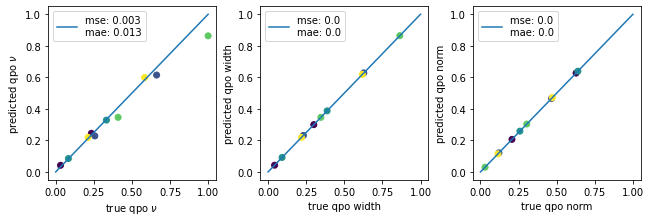

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(9,3))
fig.tight_layout()

colors = np.sort(2*list(range(len(predictions))))

ax = axs[0]
ax.scatter(test_freqs, predicted_freqs, c=colors)
ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')

ax = axs[1]
ax.scatter(test_widths, predicted_widths, c=colors)
ax.set(xlabel='true qpo width', ylabel='predicted qpo width')

ax = axs[2]
ax.scatter(test_norms, predicted_norms, c=colors)
ax.set(xlabel='true qpo norm', ylabel='predicted qpo norm')

for i in range(3):  
    ax = axs[i]
    mse = mses[i]
    mae = maes[i]
    line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
    ax.plot([0,1], [0,1], label=line_label)
    ax.legend()
    
plt.show()

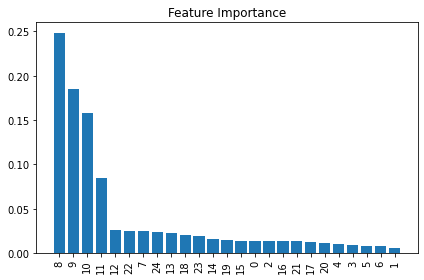

In [12]:
importances = regr.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), np.array(range(25))[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [13]:
from collections import defaultdict

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [14]:
testing_x = x.reshape(np.flip(x.shape))

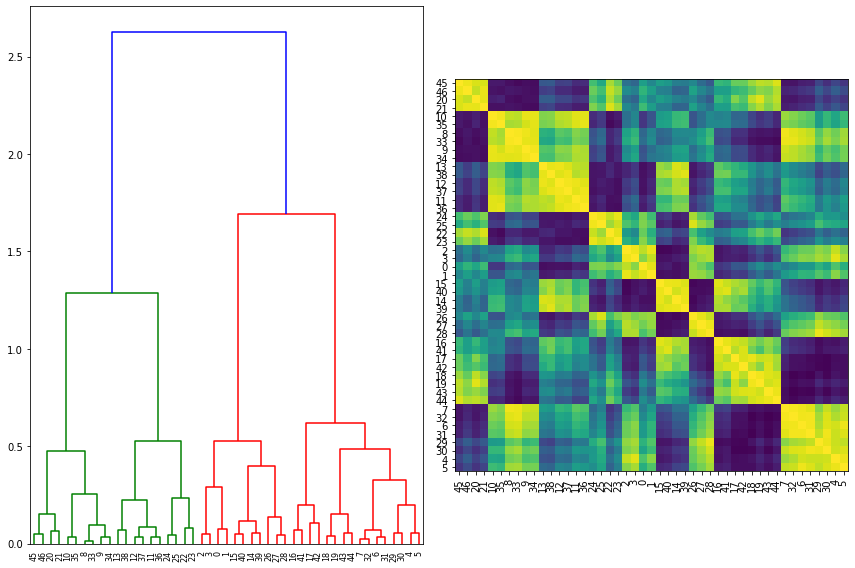

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(testing_x).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

## depression linear regression

In [18]:
from sklearn.linear_model import LinearRegression


regr = LinearRegression()
regr.fit(X_train,y_train)
predictions = regr.predict(X_test)

predicted_freqs = np.array([predictions[i][0:2] for i in range(len(predictions))])
predicted_widths = np.array([predictions[i][2:4] for i in range(len(predictions))])
predicted_norms = np.array([predictions[i][4:] for i in range(len(predictions))])

test_freqs = np.array([y_test[i][0:2] for i in range(len(y_test))])
test_widths = np.array([predictions[i][2:4] for i in range(len(y_test))])
test_norms = np.array([predictions[i][4:] for i in range(len(y_test))])

mses = [mse_score(test_freqs, predicted_freqs), mse_score(test_widths, predicted_widths), mse_score(test_norms, predicted_norms)]
maes = [mae_score(test_freqs, predicted_freqs), mae_score(test_widths, predicted_widths), mae_score(test_norms, predicted_norms)]

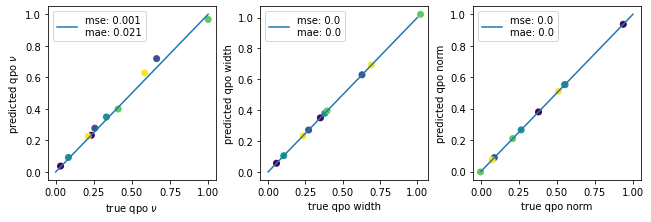

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(9,3))
fig.tight_layout()

colors = np.sort(2*list(range(len(predictions))))

ax = axs[0]
ax.scatter(test_freqs, predicted_freqs, c=colors)
ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')

ax = axs[1]
ax.scatter(test_widths, predicted_widths, c=colors)
ax.set(xlabel='true qpo width', ylabel='predicted qpo width')

ax = axs[2]
ax.scatter(test_norms, predicted_norms, c=colors)
ax.set(xlabel='true qpo norm', ylabel='predicted qpo norm')

for i in range(3):  
    ax = axs[i]
    mse = mses[i]
    mae = maes[i]
    line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
    ax.plot([0,1], [0,1], label=line_label)
    ax.legend()
    
plt.show()

## evaluate for different bin sizes

In [16]:
def evaluate(bins): 
    # package x values

    x = []

    for i in range(len(spectral_df.index)): 
        counts_row = np.array(spectral_df.iloc[[i]])[0][1:].astype(float) 
        
        rebin_factor = int(np.floor(len(counts_row)/bins))
        
        rebined = rebin(counts_row, rebin_factor)
        x.append(rebined)

    x = np.array(x)

    # package y values

    combined_freqs = np.concatenate((qpo_df['first_freq'], qpo_df['second_freq']))
    min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
    combined_widths = np.concatenate((qpo_df['first_width'], qpo_df['second_width']))
    min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
    combined_norms = np.concatenate((qpo_df['first_norm'], qpo_df['second_norm']))
    min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

    y_col_names = ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']
    freq1s, freq2s = (norm(np.array(qpo_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names[0:2])
    width1s, width2s = (norm(np.array(qpo_df[arr_name]), min_width, max_width) for arr_name in y_col_names[2:4])
    norm1s, norm2s = (norm(np.array(qpo_df[arr_name]), min_norm, max_norm) for arr_name in y_col_names[4:])

    freqs = np.array([], dtype=float).reshape(0,2)
    widths = np.array([], dtype=float).reshape(0,2)
    norms = np.array([], dtype=float).reshape(0,2)

    y_vals = []

    for i in range(len(freq1s)): 
        row_matrix = np.array([freq1s[i], freq2s[i], width1s[i], width2s[i], norm1s[i], norm2s[i]])
        y_vals.append(row_matrix)

    y_vals = np.array(y_vals)

    #print(y_vals[0])

    X_train, X_test, y_train, y_test = train_test_split(x, y_vals, test_size=0.1, shuffle=True, random_state=rs)

    regr = RandomForestRegressor()
    regr.fit(X_train,y_train)
    predictions = regr.predict(X_test)

    predicted_freqs = np.array([predictions[i][0:2] for i in range(len(predictions))])
    predicted_widths = np.array([predictions[i][2:4] for i in range(len(predictions))])
    predicted_norms = np.array([predictions[i][4:] for i in range(len(predictions))])

    test_freqs = np.array([y_test[i][0:2] for i in range(len(y_test))])
    test_widths = np.array([predictions[i][2:4] for i in range(len(y_test))])
    test_norms = np.array([predictions[i][4:] for i in range(len(y_test))])

    mses = [mse_score(test_freqs, predicted_freqs), mse_score(test_widths, predicted_widths), mse_score(test_norms, predicted_norms)]
    maes = [mae_score(test_freqs, predicted_freqs), mae_score(test_widths, predicted_widths), mae_score(test_norms, predicted_norms)]

    fig, axs = plt.subplots(1, 3, figsize=(9,3))
    fig.tight_layout()

    colors = np.sort(2*list(range(len(predictions))))

    ax = axs[0]
    ax.scatter(test_freqs, predicted_freqs, c=colors)
    ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')

    ax = axs[1]
    ax.scatter(test_widths, predicted_widths, c=colors)
    ax.set(xlabel='true qpo width', ylabel='predicted qpo width')

    ax = axs[2]
    ax.scatter(test_norms, predicted_norms, c=colors)
    ax.set(xlabel='true qpo norm', ylabel='predicted qpo norm')

    for i in range(3):  
        ax = axs[i]
        mse = mses[i]
        mae = maes[i]
        line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
        ax.plot([0,1], [0,1], label=line_label)
        ax.legend()
        
    plt.savefig('/content/plots/'+str(bins)+'bins.png')
    plt.clf()
    plt.close()

FileNotFoundError: ignored

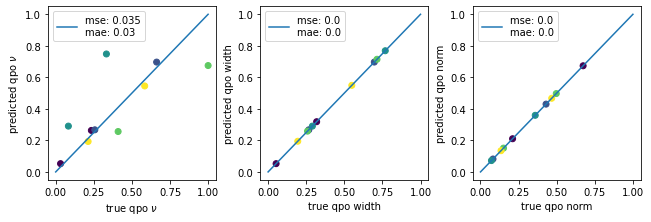

In [17]:
for bin in [1, 2, 10, 25, 50, 100, 200]: 
    evaluate(bin)